Coding a VAE using pytorch

Author: Brady Gho

Created: 18 July 2024. Last edited: 19 July 2024

In [ ]:
# Meta Parameters

Learning_rate = 0.01
Batch_size = 64
Epochs = 25
Latent = 6
Weight_decay_factor = 0.03
KL_factor = 0.3

Train Loader Images:


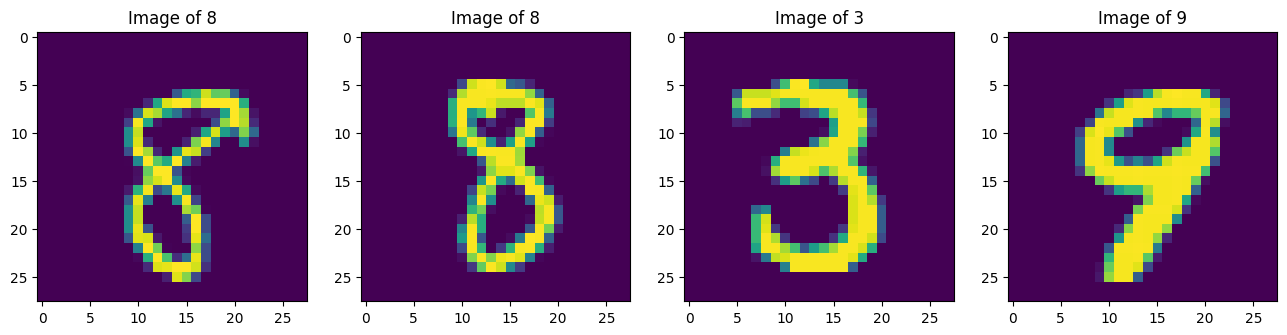

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import numpy as np
import torch.functional as F
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, transform = transform, download = True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform = transform, download = True)

train_size = int(0.8*len(trainset))
val_size = int(0.2*len(trainset))

train_data, val_data = random_split(trainset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size = Batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size = Batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size = Batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# view a couple of sample images to make sure they are loaded

print("Train Loader Images:")
images, labels = next(iter(train_loader))
images = images.cpu().detach().numpy()
plt.figure(figsize=(16, 4))
for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow(np.squeeze(images[i]))
  plt.title(f"Image of {labels[i].item()}")

plt.show()


In [ ]:
class ConvolutionalVAE(nn.Module):
  def __init__(self):
    super().__init__()

    # Encoder Layers                                                    # Original image dim: 28 x 28
    self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=1)    # image dim: 26 x 26
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                  # image dim: 13 x 13
    self.conv2 = nn.Conv2d(8, 24, kernel_size=3, stride=1)              # image dim: 11 x 11
    self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)                  # image dim: 5 x 5
    self.fc1 = nn.Linear(24*5*5, 243)
    self.fc2 = nn.Linear(243, 91)
    self.fc31 = nn.Linear(91, Latent)
    self.fc32 = nn.Linear(91, Latent)

    # Decoder Layers
    self.fc4 = nn.Linear(Latent, 91)
    self.fc5 = nn.Linear(91, 243)
    self.fc6 = nn.Linear(243, 24*5*5)
    self.upscale1 = nn.Upsample(size=11, mode='bilinear')
    self.deconv1 = nn.ConvTranspose2d(24, 8, kernel_size=3, stride=1)
    self.upscale2 = nn.Upsample(scale_factor=2, mode='bilinear')
    self.deconv2 = nn.ConvTranspose2d(8, 1, kernel_size=5, stride=1, padding=1)

    # Pytorch Functions
    self.ReLU = nn.LeakyReLU()         # Either use vanilla ReLU or leaky ReLU
    self.Sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    mu, std = self.encoder(x)
    sampled = self.sample(mu, std)
    z = self.decoder(sampled)
    return mu, std, self.Sigmoid(z)

  def encoder(self, x):
    # Convolutional layers
    x = self.ReLU(self.conv1(x))
    x = self.pool1(x)
    x = self.ReLU(self.conv2(x))
    x = self.pool2(x)

    # Flatten
    x = x.view(x.size(0), -1)

    # Mean & Std
    x = self.ReLU(self.fc1(x))
    x = self.dropout(x)
    x = self.ReLU(self.fc2(x))
    x = self.dropout(x)
    mu = self.ReLU(self.fc31(x))
    std = self.ReLU(self.fc32(x))

    return mu, std

  def sample(self, mu, std):
    random = torch.randn_like(std)
    z = std * random + mu
    return z

  def decoder(self, z):
    # Reverse fully connected Layers
    z = self.ReLU(self.fc4(z))
    z = self.dropout(z)
    z = self.ReLU(self.fc5(z))
    z = self.dropout(z)
    z = self.ReLU(self.fc6(z))

    # Rescale back to images
    z = z.view(z.size(0), 24, 5, 5)

    # Reverse Convolutional layers
    z = self.upscale1(z)
    z = self.deconv1(z)
    z = self.upscale2(z)
    z = self.deconv2(z)

    return z

VAE = ConvolutionalVAE().to(device)

optimizer = optim.Adam(VAE.parameters(), lr = Learning_rate)

In [ ]:
# !pip install torchinfo

# from torchinfo import summary
# summary(VAE, input_size=(Batch_size, 1, 28, 28))

In [ ]:
train_loss_history = []
val_loss_history = []
initial_test_loss = -1
final_test_loss = -1

In [ ]:
# Defining loss function

def calc_loss(model, image):
  mu, std, recon_x = model(image)

  # Flattening (Unecessary)
  # recon_x = recon_x.view(recon_x.size(0), -1)
  # image = image.view(image.size(0), -1)

  loss = nn.functional.binary_cross_entropy(recon_x, image, reduction='sum')

  KL_div = 0.5*torch.sum(torch.square(mu) + torch.square(std) - 1 - torch.log(torch.square(std)))

  L2_reg = 0
  for param in model.parameters():
    L2_reg += torch.sum(torch.square(param))

  total_loss = loss + (KL_factor * KL_div) + (Weight_decay_factor * L2_reg)

  # print(f"Loss: {loss}, KL divergence: {KL_div}, L2 regularizatio: {L2_reg}")
  # print(f"Total Loss: {total_loss}")

  return total_loss

Initial test loss: 513.7287


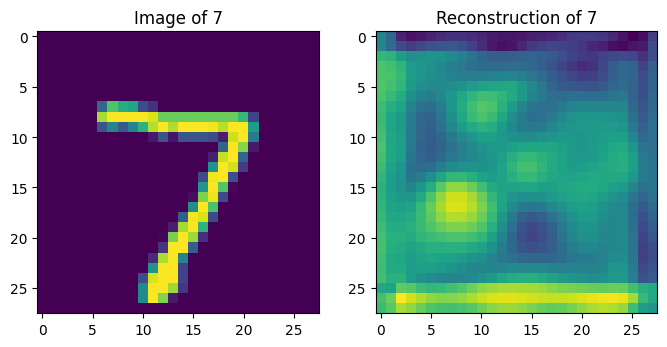

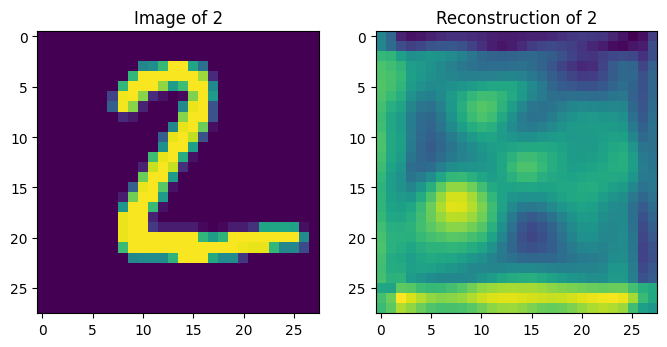

In [ ]:
# Initial evaluations

VAE.eval()
with torch.no_grad():
  total_loss = 0
  for image, _ in test_loader:
    image = image.to(device)
    total_loss += calc_loss(VAE, image)

  total_loss = (total_loss/(Batch_size*int(len(val_loader))))
  initial_test_loss = total_loss

  print(f"Initial test loss: {initial_test_loss:.4f}")

  images, labels = next(iter(test_loader))
  images = images.to(device)
  mu, std, predictions = VAE(images)
  images = images.cpu().detach().numpy()
  predictions = predictions.cpu().detach().numpy()

  for i in range(2):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(images[i]))
    plt.title(f"Image of {labels[i].item()}")

    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(predictions[i]))
    plt.title(f"Reconstruction of {labels[i].item()}")
    plt.show()


In [ ]:
# Training the model

for epoch in range(Epochs):
  total_train_loss = 0
  VAE.train()
  for image, _ in train_loader:
    image = image.to(device)
    optimizer.zero_grad()
    loss = calc_loss(VAE, image)
    total_train_loss += loss.item()
    loss.backward()
    d

  total_train_loss /= Batch_size * int(len(train_loader))
  train_loss_history.append(total_train_loss)

  VAE.eval()
  with torch.no_grad():
    total_loss = 0
    for image, _ in val_loader:
      image = image.to(device)
      total_loss += calc_loss(VAE, image)

    total_loss /= (Batch_size*int(len(val_loader)))
    val_loss_history.append(total_loss)

    print(f"Epoch {epoch+1} loss: {total_loss:.4f}")

Epoch 1 loss: 189.8776
Epoch 2 loss: 181.0693
Epoch 3 loss: 174.5836
Epoch 4 loss: 174.6116
Epoch 5 loss: 173.1125
Epoch 6 loss: 174.2682
Epoch 7 loss: 171.7952
Epoch 8 loss: 170.2818
Epoch 9 loss: 171.3244
Epoch 10 loss: 171.2805
Epoch 11 loss: 173.7786
Epoch 12 loss: 169.6112
Epoch 13 loss: 171.8941
Epoch 14 loss: 174.1252
Epoch 15 loss: 171.6898
Epoch 16 loss: 171.5992
Epoch 17 loss: 169.4829
Epoch 18 loss: 170.3202
Epoch 19 loss: 169.2509
Epoch 20 loss: 170.9817
Epoch 21 loss: 169.5160
Epoch 22 loss: 170.3844
Epoch 23 loss: 170.6537
Epoch 24 loss: 169.4697
Epoch 25 loss: 169.2857


Final test loss: 140.7823


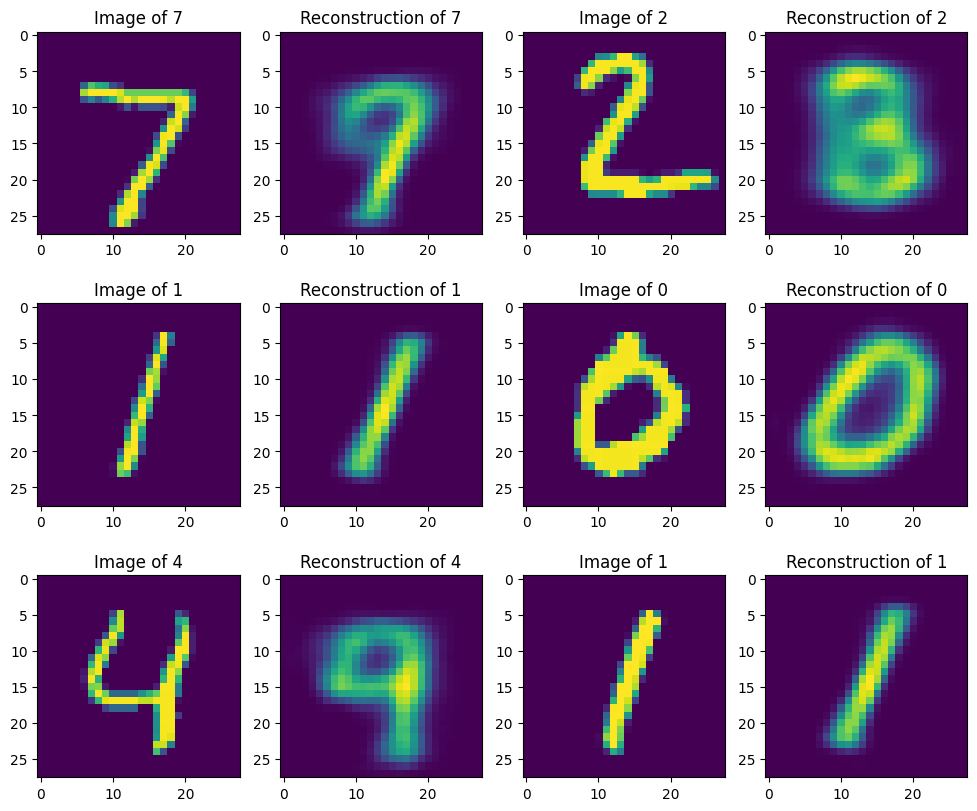

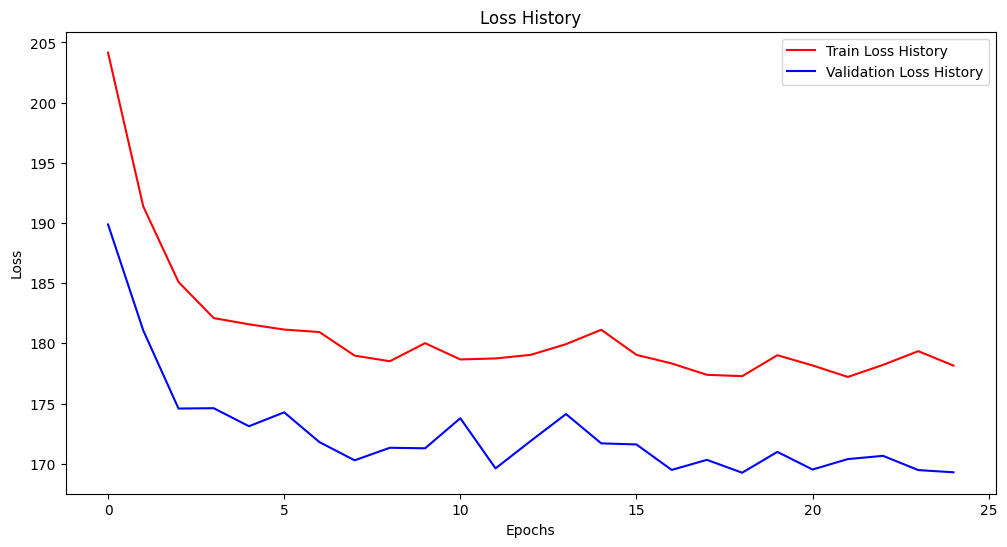

In [ ]:
# Final Evaluations

# Visualization
VAE.eval()
with torch.no_grad():
  total_loss = 0
  for image, _ in test_loader:
    image = image.to(device)
    total_loss += calc_loss(VAE, image)

  total_loss /= (Batch_size*int(len(val_loader)))
  final_test_loss = total_loss

  print(f"Final test loss: {final_test_loss:.4f}")

  images, labels = next(iter(test_loader))
  images = images.to(device)
  mu, std, predictions = VAE(images)
  images = images.cpu().detach().numpy()
  predictions = predictions.cpu().detach().numpy()

  plt.figure(figsize=(12, 10))
  for i in range(6):
    plt.subplot(3, 4, 2*i+1)
    plt.imshow(np.squeeze(images[i]))
    plt.title(f"Image of {labels[i].item()}")

    plt.subplot(3, 4, 2*i+2)
    plt.imshow(np.squeeze(predictions[i]))
    plt.title(f"Reconstruction of {labels[i].item()}")

  plt.show()


# Loss History
plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, color='r', label="Train Loss History")
plt.plot(val_loss_history, color='b', label='Validation Loss History')
plt.title("Loss History")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
